# Master Data Statistics 

This file is used for analyzing data from observations and the pre-baked synthetic data for feeding OLLA.

## Radiation Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr 
import glob 
import scipy.stats as sts

from getStats import getRemoveDefects, getPrecipEventMeansXARRAY_1D, getAutocorrelationTrunc, getDailyMeanMaxArrays

### Observational Data

Compute the mean of each day's radiation and the maximum radiation value for a given day in the observational data

In [2]:
PATH = "/data/keeling/a/adammb4/SGP_proj_2021/DATA/"
rad_data_filenames = glob.glob(PATH+"SGP_Best*")
obs_keyword = "BestEstimate_down_short_hemisp"

obs_daily_mean_array, obs_daily_max_array = getDailyMeanMaxArrays(rad_data_filenames, obs_keyword) 

0
1
2
3
4


Compute the mean of every day's mean, the maximum average daily radiation value, the minimum maximum daily radiation v alue, the standard deviation of the distribution of daily means (obs_avg_std) and the skewness of the distribution of daily mean radiation (obs_avg_skew)

In [3]:
obs_overall_avg_rad = np.mean(obs_daily_mean_array)
obs_peak_daily_rad = np.amax(obs_daily_max_array)
obs_min_daily_rad = np.amin(obs_daily_max_array)
obs_avg_std = np.std(obs_daily_mean_array)
obs_avg_skew = sts.skew(obs_daily_mean_array)
#obs_overall_avg_std = np.mean(obs_daily_std_array)
#obs_overall_avg_skew = np.mean(obs_daily_skew_array)

print(obs_overall_avg_rad, obs_peak_daily_rad, obs_min_daily_rad, obs_avg_std, obs_avg_skew, np.amax(obs_daily_mean_array))

475.5700796547502 1290.0750732421875 148.78173828125 106.99830204164722 -1.4261204198965 624.9691718089807


### Synthetic Data

Same as above for synthetic data.

In [4]:
synth_filenames = glob.glob(PATH+"SGP_synth*")
syn_keyword = "F_solar"

syn_daily_mean_array, syn_daily_max_array = getDailyMeanMaxArrays(synth_filenames, syn_keyword)

0


In [5]:
syn_overall_avg_rad = np.mean(syn_daily_mean_array)
syn_peak_daily_rad = np.amax(syn_daily_max_array)
syn_min_daily_rad = np.amin(syn_daily_max_array)
syn_avg_std = np.std(syn_daily_mean_array)
syn_avg_skew = sts.skew(syn_daily_mean_array)
#syn_overall_avg_std = np.mean(syn_daily_std_array)
#syn_overall_avg_skew = np.mean(syn_daily_skew_array)

print(syn_overall_avg_rad, syn_peak_daily_rad, syn_min_daily_rad, syn_avg_std, syn_avg_skew)

365.15822881229116 1290.0750732421875 363.33990478515625 100.38182998993194 -0.8417640858360241


Plot the distrbution of daily radition means and maxima.

'\nax[1,2].hist(syn_daily_std_array, color=\'red\')\nax[1,2].set_xlabel("Daily Standard Deviation")\nax[1,2].set_ylabel("Frequency")\n\nax[1,3].hist(syn_daily_skew_array, color=\'red\')\nax[1,3].set_xlabel("Daily Skewness")\nax[1,3].set_ylabel("Frequency")\n'

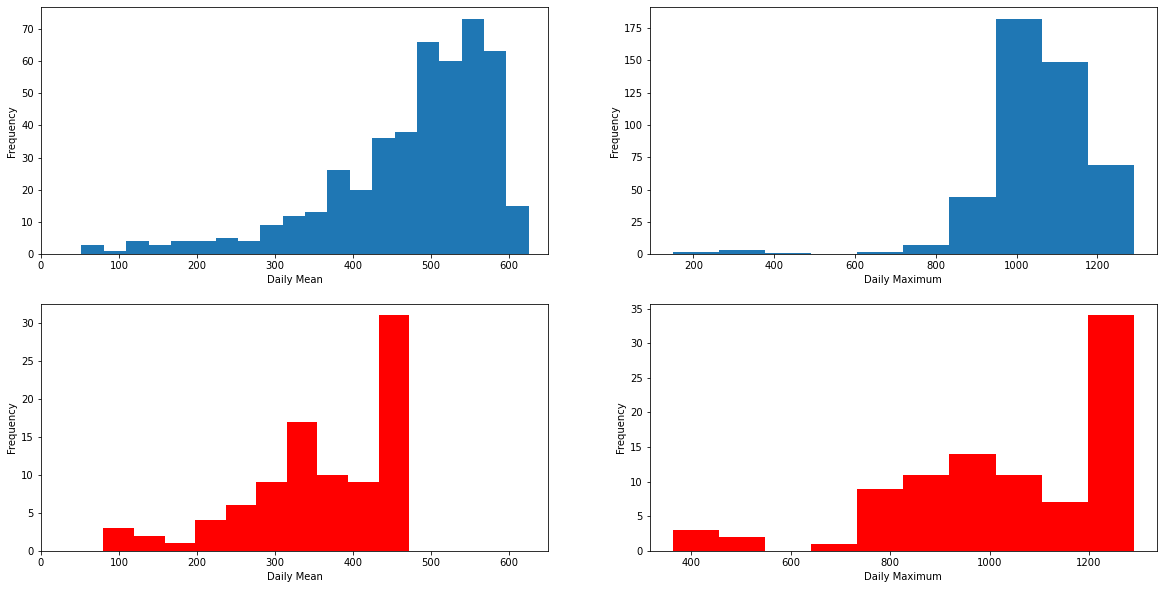

In [9]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].hist(obs_daily_mean_array,20)
ax[0,0].set_xlabel("Daily Mean")
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_xlim((0,650))

ax[0,1].hist(obs_daily_max_array)
ax[0,1].set_xlabel("Daily Maximum")
ax[0,1].set_ylabel("Frequency")


ax[1,0].hist(syn_daily_mean_array, color='red')
ax[1,0].set_xlabel("Daily Mean")
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_xlim((0,650))

ax[1,1].hist(syn_daily_max_array, color='red')
ax[1,1].set_xlabel("Daily Maximum")
ax[1,1].set_ylabel("Frequency")

Compute the autocorrelation of the distribution of daily means.

In [ ]:
obs_auto = getAutocorrelationTrunc(np.std(obs_daily_mean_array)**(-1) * (obs_daily_mean_array - np.mean(obs_daily_mean_array)) )
syn_auto = getAutocorrelationTrunc(np.std(syn_daily_mean_array)**(-1) * (syn_daily_mean_array - np.mean(syn_daily_mean_array)) )

#obs_auto = np.correlate(obs_daily_mean_array,obs_daily_mean_array,mode='full') # t \in (-infty, infty)
#syn_auto = np.correlate(syn_daily_mean_array,syn_daily_mean_array,mode='full') # t \in (-infty, infty)

avg_obs_auto = np.mean(obs_auto)
avg_syn_auto = np.mean(syn_auto)

print(avg_obs_auto, avg_syn_auto)

fig, ax = plt.subplots(1, figsize=(15,7.5))

ax.plot(obs_auto * (len(obs_daily_mean_array))**(-1), color='blue', label="observation")
ax.plot(syn_auto * (len(syn_daily_mean_array))**(-1), color='red', label="synthetic")
ax.legend()
ax.set_xlim((0,5))
ax.set_ylim((-0.25,1))

## Precip Data

In [ ]:
PATH = "/data/keeling/a/adammb4/SGP_proj_2021/DATA/"
obs_precip_filenames = glob.glob(PATH+"SGP_precip*")
syn_precip_filenames = glob.glob(PATH+"SGP_synth*")

obs_mean_event_array = getPrecipEventMeansXARRAY_1D(obs_precip_filenames, 0, "precip")
syn_mean_event_array = getPrecipEventMeansXARRAY_1D(syn_precip_filenames, 0, "precip_syn")

Plot the distribution of the daily precipitation event amounts.

In [ ]:
fig, ax = plt.subplots(1,2)

ax[0].hist(obs_mean_event_array)
ax[1].hist(syn_mean_event_array)

# Average Diurnal Cycle

## Radiation

In [10]:
PATH = "/data/keeling/a/adammb4/SGP_proj_2021/DATA/"
rad_data_filenames = glob.glob(PATH+"SGP_Best*")
syn_data_filenames = glob.glob(PATH+"SGP_sy*")
obs_keyword = "BestEstimate_down_short_hemisp"
syn_keyword = "F_solar"

### Observational Data

In [11]:
N_files = len(rad_data_filenames)

clean_rad_data = np.zeros((5,92*24*60))

# clean observational data

for i in range(0, N_files):
    tmp_ds = xr.open_dataset(rad_data_filenames[i])
    clean_rad_data[i] = getRemoveDefects(tmp_ds[obs_keyword].values, obs_keyword)

In [12]:
# take the mean of each minute's value over 5 years
clean_avg_summer_cycle = np.mean(clean_rad_data, axis=0)

# split into daily diurnal cycle
clean_avg_summer_cycle_split = np.split(clean_avg_summer_cycle, 92)

In [16]:
# mean over daily minute by minute
clean_avg_daily_cycle = np.mean(clean_avg_summer_cycle_split, axis=0)
#len(clean_avg_daily_cycle)
np.amax(clean_avg_daily_cycle)

834.9610489565479

### Synthetic Data

In [14]:
synds = xr.open_dataset(syn_data_filenames[0])
syn_rad = synds["F_solar"].values[:,0]
syn_rad_split = np.split(syn_rad, 92)
syn_rad_avg_cycle = np.mean(syn_rad_split, axis=0)
#syn_rad_avg_cycle

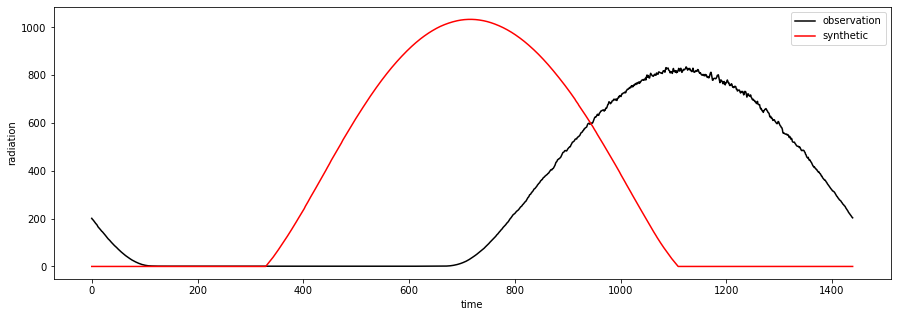

In [15]:
fig, ax = plt.subplots(1, figsize=(15,5))

ax.plot(clean_avg_daily_cycle, color='k', label='observation')
ax.plot(syn_rad_avg_cycle, color='r', label='synthetic')
ax.set_xlabel("time")
ax.set_ylabel("radiation")
ax.legend()

## Precipitation

### Observational Data

In [ ]:
PATH = "/data/keeling/a/adammb4/SGP_proj_2021/DATA/"
obs_precip_filenames = glob.glob(PATH+"SGP_precip*")
obs_keyword = "precip"

# one day had less day's worth of data than the other ones so this needed to be done individually.

ds0 = xr.open_dataset(obs_precip_filenames[0])
precip0 = ds0["precip"].values

clean_precip0 = getRemoveDefects(precip0, "precip")

ds1 = xr.open_dataset(obs_precip_filenames[1])
precip1 = ds1["precip"].values

clean_precip1 = getRemoveDefects(precip1, "precip")

ds2 = xr.open_dataset(obs_precip_filenames[2])
precip2 = ds2["precip"].values

clean_precip2 = getRemoveDefects(precip2, "precip")

ds3 = xr.open_dataset(obs_precip_filenames[3])
precip3 = ds3["precip"].values

clean_precip3 = getRemoveDefects(precip3, "precip")

ds4 = xr.open_dataset(obs_precip_filenames[4])
precip4 = ds4["precip"].values

clean_precip4 = getRemoveDefects(precip4, "precip")

In [ ]:
# make filler array and append it to precip2 to make all of the arrays above the same size
filler = np.full(1440, None)
clean_precip2_filled = np.hstack((clean_precip2, filler))
#len(filler)
#len(clean_precip2_filled)

stack all of the precip arrays to make a matrix 

In [ ]:
clean_precip_all = np.vstack((clean_precip0, clean_precip1, clean_precip2_filled, clean_precip3, clean_precip4))

In [ ]:
# hand calc mean

min_mean = np.zeros(92*60*24)

for i in range(0, len(clean_precip_all[0])):
    
    tmp_sum = 0
    
    if clean_precip_all[2][i] == None:
        tmp_sum = clean_precip_all[0][i] + clean_precip_all[1][i] + clean_precip_all[3][i] + clean_precip_all[4][i]
        tmp_mean = tmp_sum * (4)**(-1)
        min_mean[i] = tmp_mean
        
    else: 
        tmp_sum = clean_precip_all[0][i] + clean_precip_all[1][i] + clean_precip_all[3][i] + clean_precip_all[4][i] + clean_precip_all[2][i]
        tmp_mean = tmp_sum * (5)**(-1)
        min_mean[i] = tmp_mean

In [ ]:
clean_avg_summer_cycle_split_precip = np.split(min_mean, 92) # split into daily cycles
avg_daily_cycle_precip = np.mean(clean_avg_summer_cycle_split_precip, axis=0) # take minute mean of precip in a day

### Synthetic Data

In [ ]:
synds = xr.open_dataset(syn_data_filenames[0])
syn_precip = synds["precip_syn"].values[:,0]
syn_precip_split = np.split(syn_precip, 92)
syn_precip_avg_cycle = np.mean(syn_precip_split, axis=0)
#syn_precip_avg_cycle

Plot results.

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,5))

ax.plot(avg_daily_cycle_precip, color='k', label='observation', zorder=4)
ax.plot(syn_precip_avg_cycle, color='r', label='synthetic')
ax.set_xlabel("time")
ax.set_ylabel("precip")
ax.legend()

## Testing Grounds

In [ ]:
synth_filenames = glob.glob(PATH+"SGP_synth*")

ds = xr.open_dataset(synth_filenames[0])

rad = ds["F_solar"].values

rad[699][0]

In [ ]:
ds = xr.open_dataset(rad_data_filenames[0])
rad = ds["BestEstimate_down_short_hemisp"].values

rad_clean = getRemoveDefects(rad, "BestEstimate_down_short_hemisp")

In [ ]:
rad_split = np.split(rad, 92)
rad_clean_split = np.split(rad_clean, 92)

fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(rad_split[0])
ax[0].set_ylim(-3000, 1400)

ax[1].plot(rad_clean_split[0])
ax[1].set_ylim(-3000,1400)